## Student Name:


## Student ID:

# Imports

You should not import any further functionality. If you feel this is required to complete the task, please discuss with your moderator.

In [1]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# imported to keep track of compute time if you wish
import sys
np.set_printoptions(threshold=sys.maxsize)
import time

In [3]:
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve

# Provided code
The below code is not necessarily complete or applicable to all tasks. Read and understand the code so that you can use wisely and adapt as required.

In [4]:
def plot_margin(X, y, clf, title):

    # increasing the figure size for bette display
    plt.figure(figsize=(8,8))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)


    # plot the decision function
    ax = plt.gca()
    ax.set_aspect(aspect=1)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')
    # calling show with names
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.show()

To compare the SVM with a NN:

In [5]:
def plot_decisions(X, y, title, model):
    # define bounds of the domain
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    yhat = model.predict(grid)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')
    plt.title(title)
    # create scatter plot for samples from each class
    for class_value in range(2):
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')
    plt.show()

In [6]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    #plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    plt.title(title)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_errors = 1- train_scores
    test_errors = 1-test_scores

    train_errors_mean = np.mean(train_errors, axis=1)
    train_errors_std = np.std(train_errors, axis=1)
    test_errors_mean = np.mean(test_errors, axis=1)
    test_errors_std = np.std(test_errors, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_errors_mean - train_errors_std,
                     train_errors_mean + train_errors_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_errors_mean - test_errors_std,
                     test_errors_mean + test_errors_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_errors_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_errors_mean, 'o-', color="g",
             label="Test error")


    plt.legend(loc="best")
    return plt

This wrapper is required in below BayesSearchCV for a neural network to combine the two layer arguments (or more if you wish to experiment with more than two layers) into the single hidden_layer_sizes hyper-parameter.

In [7]:
class MLPWrapper(BaseEstimator, ClassifierMixin):

    def __init__(self, layer1=10, layer2=10, activation='relu', alpha=0.1):
        self.layer1 = layer1
        self.layer2 = layer2
        self.activation = activation
        self.alpha = alpha

    def fit(self, X, y):
        model = MLPClassifier(
            hidden_layer_sizes=[self.layer1, self.layer2], activation=self.activation, alpha = self.alpha,
            max_iter = 1000,
        )
        model.fit(X, y)
        self.model = model
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

## Modified the code to include a number of hyper parameters, reducing the number of iterations to run on local machine

In [8]:
# Example use of BayesSearchCV to search a large search space whilst keeping compute requirements in check
# adding random state and modifying the parameters
optSVM1_lin = BayesSearchCV(
    svm.SVC(),
    {
      'C': Real(1e-3, 1e+3, prior='log-uniform'),
      'gamma': [0.0001, 0.0009, 0.001, 0.01, 0.1], 'degree' : [2,3,5,7],
        'kernel': Categorical(['linear', 'rbf', 'poly']),
    },
    n_iter=50,
    random_state = 42,
)

In [9]:
# Example use of BayesSearchCV with the MLPWrapper to vary the layer sizes

optNN1 = BayesSearchCV(
    estimator=MLPWrapper(),
    search_spaces={
        'layer1': Integer(10, 20),
        'layer2': Integer(10, 20),
        'activation':('relu', 'tanh', 'logistic'), 'alpha':Real(0.001, 0.1, prior='log-uniform'),
    },
    n_iter=50,
)

In [10]:
import warnings

# suppressing warnings
warnings.filterwarnings("ignore")

# Solutions

## Task 1

## Import training data

In [11]:
import pandas as pd
df = pd.read_csv("dataset_1_train.csv", header = None)
display(df) # display the dataframe

X = df.iloc[:, 0:2]
y = df.iloc[:, -1]

,0,1,2
0,0.913385,-0.131071,1.0
1,-1.393895,-1.373790,0.0
2,-0.379568,1.404829,0.0
3,1.525722,-1.713379,1.0
4,1.444181,-0.622548,1.0
...,...,...,...
996,-1.247179,-1.562549,0.0
997,0.272633,0.020601,1.0
998,-0.222179,1.051096,0.0
999,0.758902,-1.624465,1.0


## Train the model

In [12]:
model = svm.SVC(kernel = "linear", C = 0.001, random_state = 42)
# as mentioned in the question using the entire X for training
model = model.fit(X, y)

## Describe accuracy vs C_values

In [13]:
def accuracy_vs_c_values(X, y, c_values = np.linspace(0.0000001, 0.25, num = 5)):

  for c in c_values :

    model = svm.SVC(kernel = "linear", C = c, random_state = 42)
    model = model.fit(X, y)
    accuracy = model.score(X, y)
    print(f"C value : {c}, accuracy = {accuracy}" )
    # plot_learning_curve(model, f"SVM with C = {c} with accuracy value of {accuracy}", X, y).show()
    # plot_decisions(X.values, y.values, f"SVM with C = {c} with accuracy value of {accuracy}", model)
    # plot_margin(X, y, model)


In [14]:
accuracy_vs_c_values(X, y) # print a few values of accuracy with a few c values

C value : 1e-07, accuracy = 0.5004995004995005
C value : 0.062500075, accuracy = 0.999000999000999
C value : 0.12500005, accuracy = 1.0
C value : 0.18750002500000001, accuracy = 1.0
C value : 0.25, accuracy = 1.0


<span style = "color:green">This tells us as the C value increases the accuracy increases</span>

## Plotting soft margin and hard margin using a lower c value and a high c value

### Define function of plotting the various graphs

In [15]:

def train_model_and_plot(type_of):
  model = svm.SVC(kernel = "linear", C = c_value, random_state = 42)
  model = model.fit(X, y)
  accuracy = model.score(X, y)
  print(f"C value : {c_value}, accuracy = {accuracy}" )
  plot_learning_curve(model, f"SVM with C = {c_value} with accuracy value of {accuracy}", X, y).show()
  plot_decisions(X.values, y.values, f"SVM with C = {c_value} with accuracy value of {accuracy}", model)
  plot_margin(X.values, y, model, f"{type_of} (c = {c_value})")
  print("Number of Support vectors :", len(model.support_vectors_))

### Soft Margin(low c value)

C value : 0.001, accuracy = 0.998001998001998


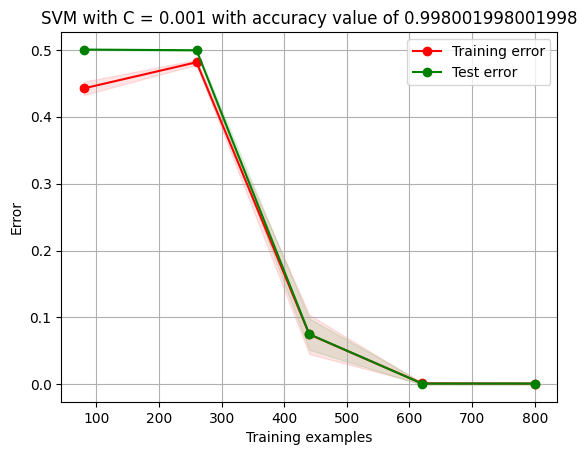

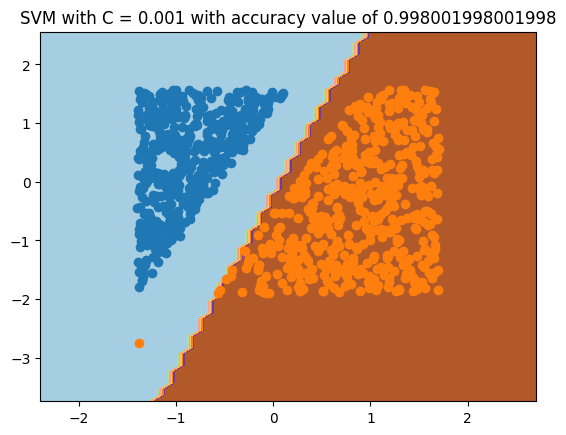

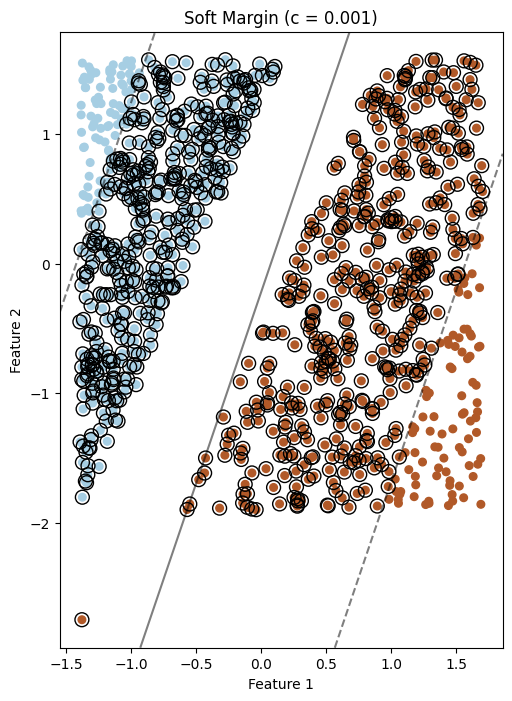

Number of Support vectors : 832


In [16]:
c_value = 0.001
train_model_and_plot("Soft Margin")

<span style = "color:green">The above figures and plots tell us that the lower the c value, higher the gap beween the support vectors. As can be seen when the c value is 0.001 then the accuracy is 0.998, and the gap between the support vectors is large, which tells us the number of support vectors is also large(832 in this case)</span>

### Hard Margin

C value : 100, accuracy = 1.0


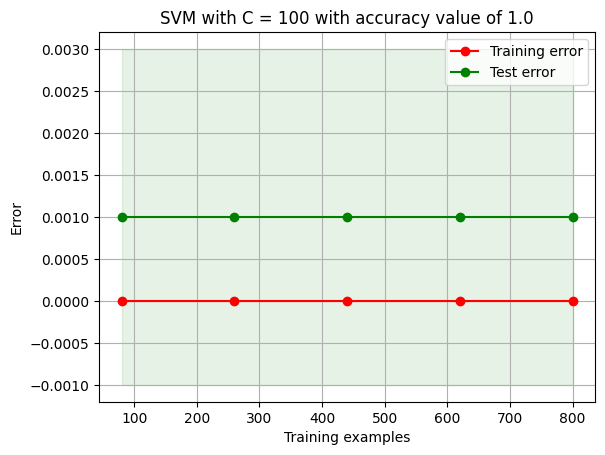

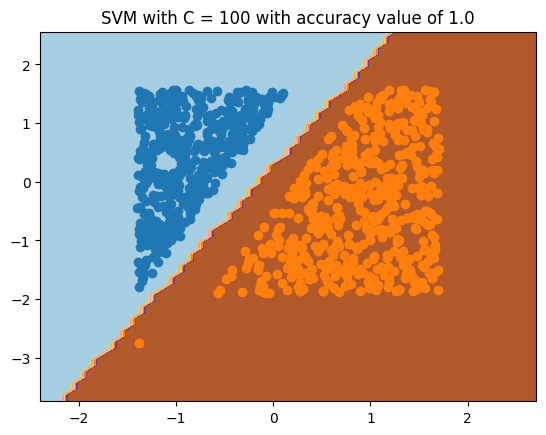

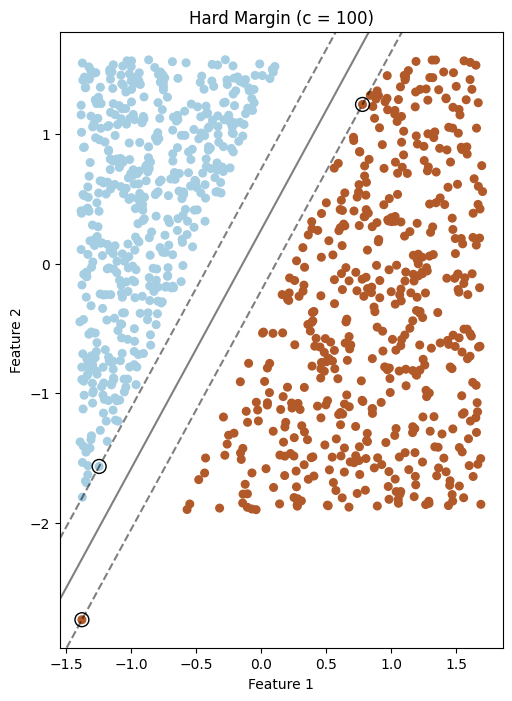

Number of Support vectors : 3


In [17]:
c_value = 100
train_model_and_plot("Hard Margin")

<span style = "color:green">The above figures and plots tell us that the higher the c value, lower the gap beween the support vectors. As can be seen when the c value is 100 then the accuracy is 1, and the gap between the support vectors is small, which tells us the number of support vectors is also small(3 in this case). However, we typically want the gap to be more there by allowing some missclassification which accounts for better generalization</span>

## Reflection

<span style = "color:green">The target of Support Vector Machine is to \frac{2}{\|w\|} term, which is done by minimizing wTw/2 with the condition y(wT.x + b) >=1. This quadratic constrained optimization can be solved using Lagrange multipliers. For an ideal solution many of the multipliers would be 0. The non-zero multipliers would determine the support vectors, which would be corresponding to the points on the margins, which are defined as support vectors. This maximize the gap between the vectors. The Number of support vectors determine the gap we have in between the support vectors.</span>

<span style = "color:green">The targer here is to obtain a bigger margin as it would generalize well to out-of-sample data. Hence we prefer the soft margin. For a soft margin classifier, the in-sample error would be bigger when compared to the hard margin classifer, due to the fact that it allows for a more generalized boundary. Hence reducing the value of C increases the margin. This can be viewed as a method of regularization similar to lambdas, however opposite. ie. C = 1/lambda. Increase in C would lead to lowering of regularizaion hence would form a hard margin, and decreasing C would lead to higher regularization, whereby the model performs better for out-of-sample data, due to better generalization.</span>

# Task 2

## Function: Read data

In [18]:
import pandas as pd

def load_data_dataset(train_data, test_data):
  # load data
  df_train = pd.read_csv(train_data, header = None)
  df_test = pd.read_csv(test_data, header = None)
  # display(df) # display the dataframe
  return df_train, df_test

def load_train_test_data(df_train, df_test):
  X_train = df_train.iloc[:, 0:2]
  y_train = df_train.iloc[:, -1]
  X_test = df_test.iloc[:, 0:2]
  y_test = df_test.iloc[:, -1]
  return X_train, y_train, X_test, y_test

# Dataset 2

In [19]:
df_train, df_test = load_data_dataset("dataset_2_train.csv", "dataset_2_test.csv")
X_train, y_train, X_test, y_test = load_train_test_data(df_train, df_test)

<span style = "color:green">Testing a few SVMs with different Kernels</span>

## Testing with poly kernel with degree 2

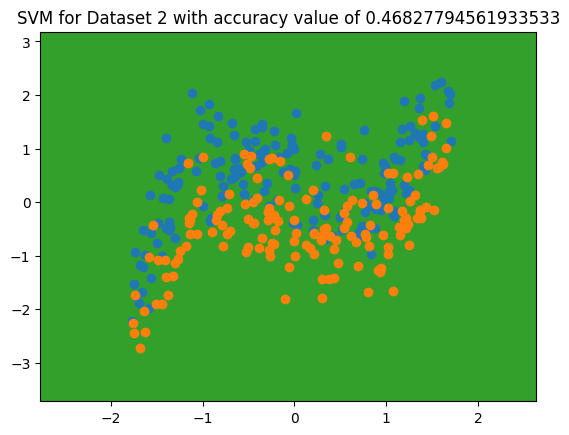

In [20]:
model = svm.SVC(kernel = "poly", degree = 2, random_state = 42)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
plot_decisions(X_test.values, y_test, f"SVM for Dataset 2 with accuracy value of {accuracy}", model)
print()


## Testing with rbf kernel

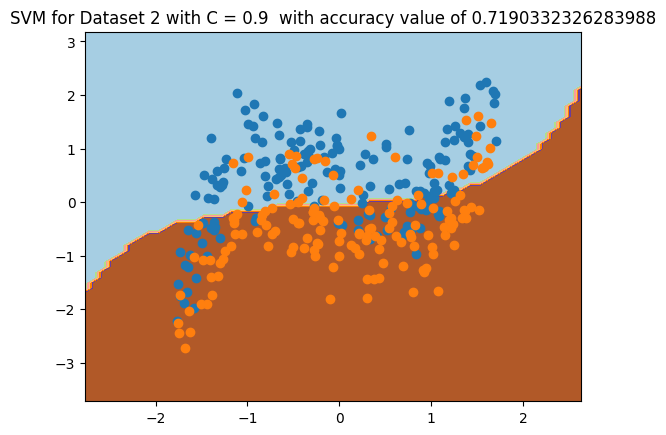

In [21]:
model = svm.SVC(kernel='rbf', C=0.9, gamma=0.1, random_state=42)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
plot_decisions(X_test.values, y_test, f"SVM for Dataset 2 with C = 0.9  with accuracy value of {accuracy}", model)
print()


## Testing with Sigmoid Kernel

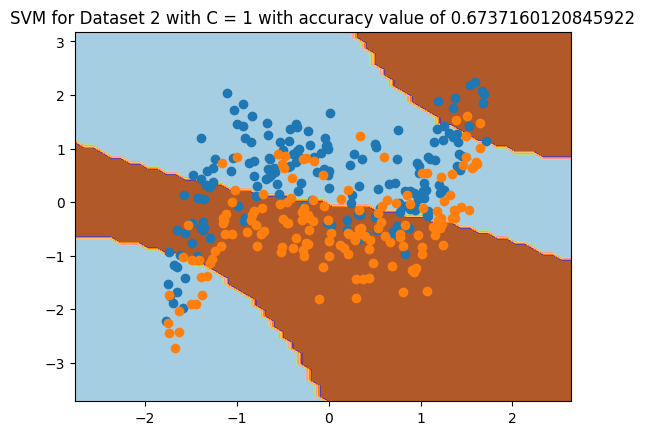

In [22]:
model = svm.SVC(kernel='sigmoid', C=1.0, gamma='auto', coef0=0.0, random_state=42)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
plot_decisions(X_test.values, y_test, f"SVM for Dataset 2 with C = 1 with accuracy value of {accuracy}", model)
print()


## **Getting the optimal model parameters for Dataset 2 using Grid Search CV**

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# define parameters to try out
parameter_grid = [
    {'C': [0.0001, 0.001, 0.01, 0.1, 10, 33, 34, 36, 100], 'kernel': ['linear']},
    {'C': [0.0001, 0.001, 0.01, 0.1, 10, 33, 34, 36, 100], 'gamma': [0.001, 0.01, 0.1], 'kernel': ['rbf']},
    {'C': [0.0001, 0.001, 0.01, 0.1, 10, 33, 34, 36, 100], 'gamma': [0.001, 0.01, 0.1], 'kernel': ['poly'], 'degree':[2,3,4]}]

model = SVC()
# fit the train data to SVC and apply grid search using 5 fold cross validation
grid_search = GridSearchCV(model, parameter_grid, cv = 5)
grid_search.fit(X_train, y_train)

# identify the best parameters
best_params = grid_search.best_params_

print("The best parameters are :", best_params)

# use the best_estimator_ to obtain the best model and predict the result
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

# calculate the accuracy
# print(f"Accuracy of Dataset 2 with {best_params['kernel']} kernel with gamma value of {best_params['gamma']} and degree of {best_params['degree']} and C value of {best_params['C']} is :", accuracy)
print(f"Accuracy of Dataset 2 with {best_params['kernel']} kernel with gamma value of {best_params['gamma']} and C value of {best_params['C']} is :", accuracy)


The best parameters are : {'C': 34, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy of Dataset 2 with rbf kernel with gamma value of 0.1 and C value of 34 is : 0.7583081570996979


# Function: Plot decision boundary and margins with learning curve

In [24]:
def plot_learning_curve_decision_boundary_margin(best_params, X_test, y_test, accuracy, best_estimator, dataset_title):
  # plot learning curve for the best estimator
  plot_learning_curve(best_estimator, f"SVM for {dataset_title} with C = {best_params['C']}, gamma = {best_params['gamma']}, kernel = {best_params['kernel']} with accuracy value of {accuracy}", X_test, y_test).show()
  # plot decision boundary
  plot_decisions(X_test.values, y_test.values, f"SVM for {dataset_title} with C = {best_params['C']}, gamma = {best_params['gamma']}, kernel = {best_params['kernel']} with accuracy value of {accuracy}", best_estimator)
  # plot margin for dataset
  plot_margin(X_test.values, y_test.values, best_estimator, f"Margin for {dataset_title}")
  # Total number of support vectors
  print("Number of support vectors : ", len(best_estimator.support_vectors_))

## Plot learning curve, decision boundary and margin for Dataset 2

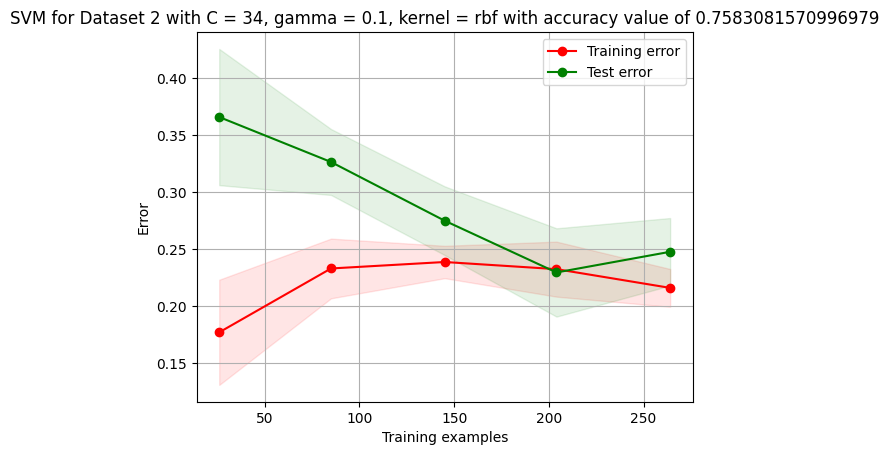

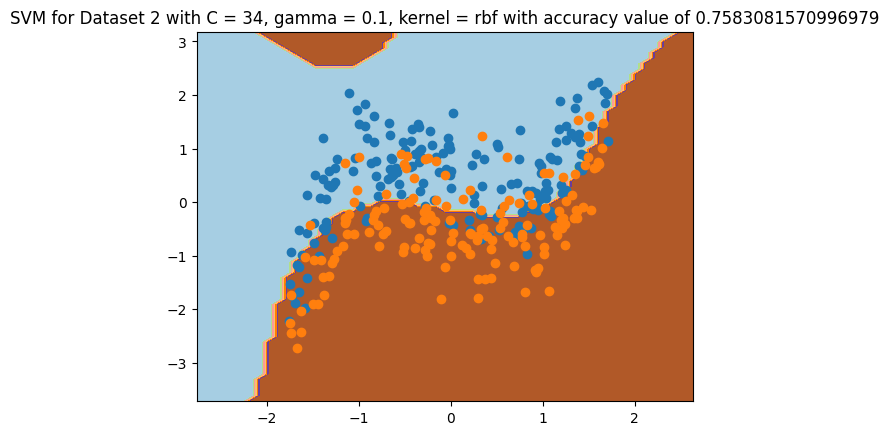

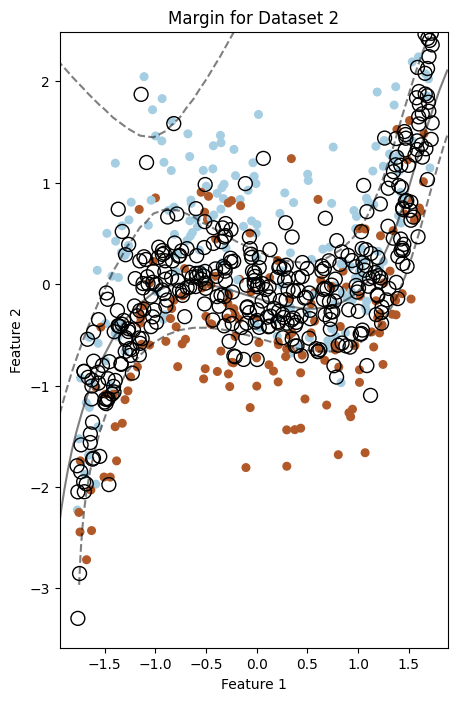

Number of support vectors :  381


In [25]:
plot_learning_curve_decision_boundary_margin(best_params, X_test, y_test, accuracy, best_estimator, "Dataset 2")

<span style="color:green">The number of support vectors = 381 and the best c value is 34 with gamma of 0.1 and rbf kernel as per the grid search, with an accuracy score of 0.7583081570996979</span>

# Function: Bayes Search to obtain Best Parameters for SVM and calculate the accuracy

In [26]:
def best_parameters_with_bayes_search(X_train, y_train):
  np.int = np.int64
  optSVM1_lin.fit(X_train, y_train)

  # Get the best parameters and score
  best_params = optSVM1_lin.best_params_
  accuracy = optSVM1_lin.best_score_
  model = optSVM1_lin.best_estimator_
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print("Best Parameters:", best_params)
  print("Accuracy:", optSVM1_lin.best_score_)
  return optSVM1_lin

# Print best parameters obtained with Bayes Search

In [27]:
bayes_search_results = best_parameters_with_bayes_search(X_train, y_train)

Best Parameters: OrderedDict([('C', 34.83719088201435), ('degree', 7), ('gamma', 0.1), ('kernel', 'rbf')])
Accuracy: 0.7746268656716417


# Plotting the graph using the parameters provided by Bayes Search

In [28]:
# plot_decisions(X_test.values, y_test, f"SVM for Dataset 2(Bayes Search) with C = {bayes_search_results.best_params_['C']} with accuracy value of {accuracy}", bayes_search_results.best_estimator_)
# print()


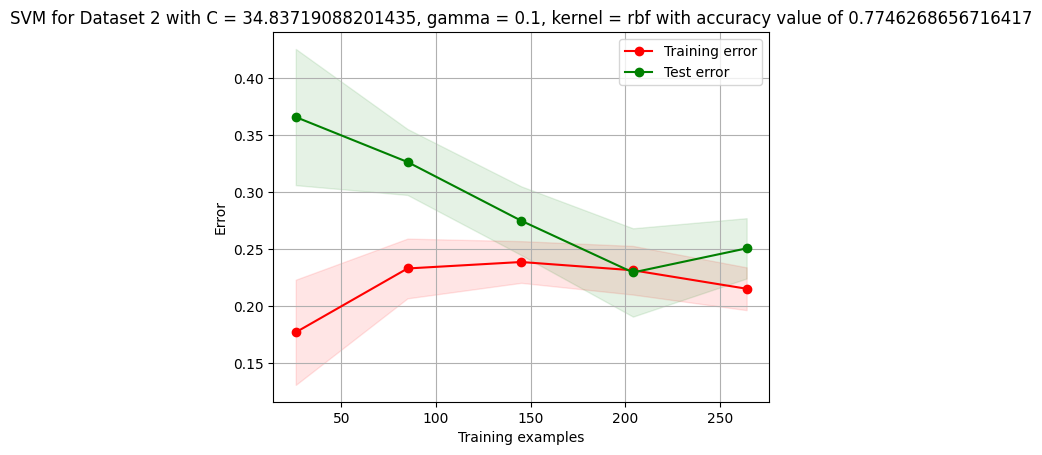

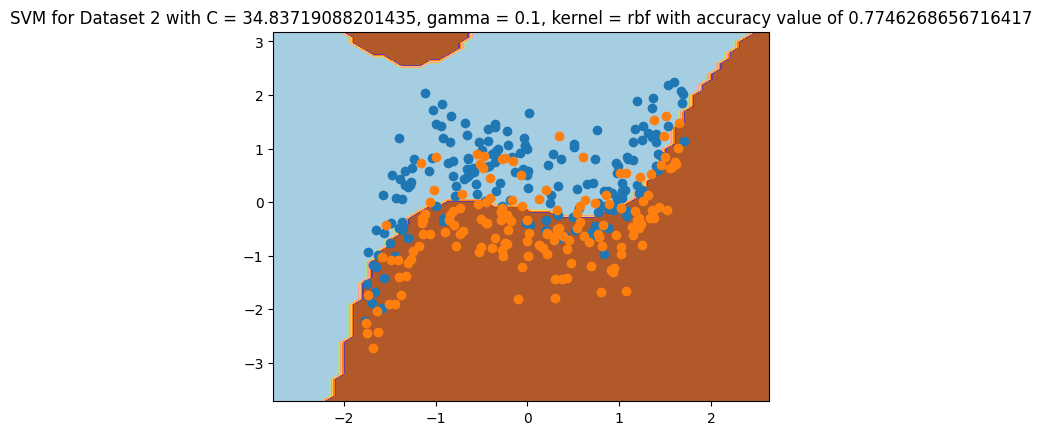

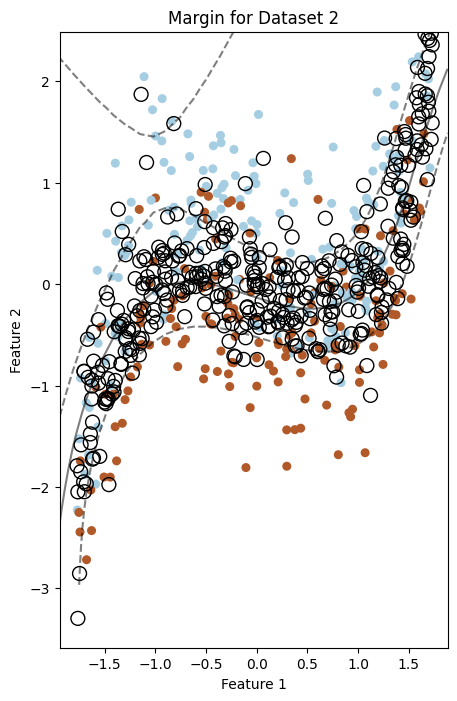

Number of support vectors :  380


In [29]:
best_params['C'] = bayes_search_results.best_params_['C']
best_params['gamma'] = bayes_search_results.best_params_['gamma']
best_params['kernel'] = bayes_search_results.best_params_['kernel']
plot_learning_curve_decision_boundary_margin(best_params, X_test, y_test, bayes_search_results.best_score_, bayes_search_results.best_estimator_, "Dataset 2")

<span style="color:green">The number of support vectors = 380 and the best c value is 34 with gamma of 0.1 and rbf kernel as per the grid search, with an accuracy score of 0.7746268656716417</span>

# **Dataset 3**

Read data

In [30]:
df_train, df_test = load_data_dataset("dataset_3_train.csv", "dataset_3_test.csv")
X_train, y_train, X_test, y_test = load_train_test_data(df_train, df_test)

In [31]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

parameter_grid = [
    {'C': [0.0001, 0.001, 0.01, 0.1, 10, 100], 'kernel': ['linear']},
    {'C': [0.0001, 0.001, 0.01, 0.1, 10, 100], 'gamma': [0.001, 0.01, 0.1], 'kernel': ['rbf']},
    {'C': [0.0001, 0.001, 0.01, 0.1, 10, 100], 'gamma': [0.001, 0.01, 0.1], 'kernel': ['poly'], 'degree':[2,3,4]}]

model = SVC()

# fit the train data to SVC and apply grid search using 5 fold cross validation
grid_search = GridSearchCV(model, parameter_grid, cv = 5)
grid_search.fit(X_train, y_train)

# identify the best parameters
best_params = grid_search.best_params_

print("The best parameters are :", best_params)

# use the best_estimator_ to obtain the best model and predict the result
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)
accuracy_best = grid_search.best_score_
accuracy = accuracy_score(y_test, y_pred)

# calculate the accuracy
print(f"Accuracy of Dataset 3 with {best_params['kernel']} kernel with gamma value of {best_params['gamma']} and degree of {best_params['degree']} and C value of {best_params['C']} is :", accuracy)


The best parameters are : {'C': 100, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'}
Accuracy of Dataset 3 with poly kernel with gamma value of 0.1 and degree of 2 and C value of 100 is : 0.9636363636363636


## Plot learning curve, decision boundary and margin for Dataset 3

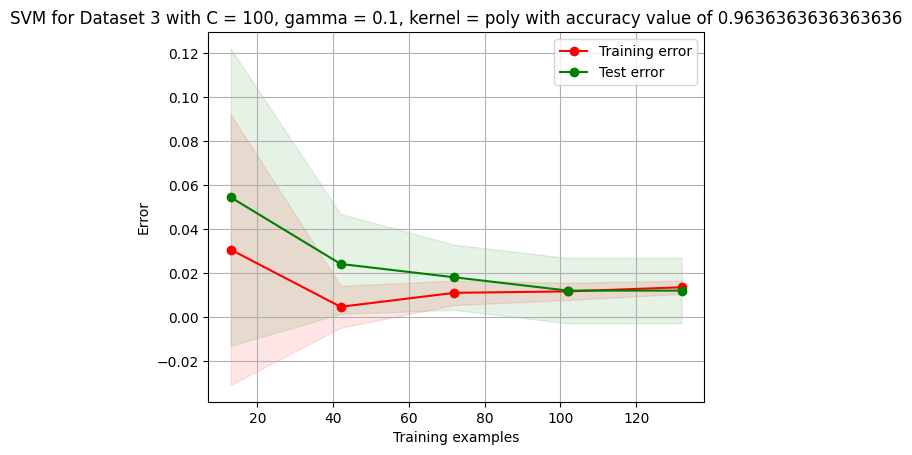

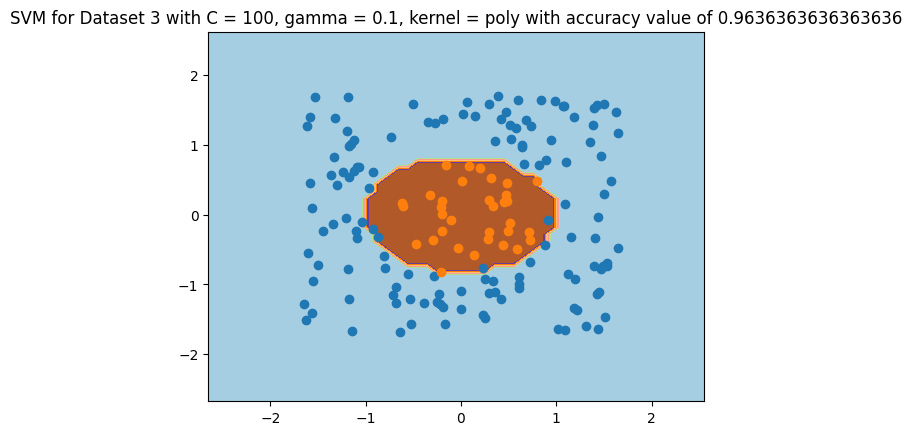

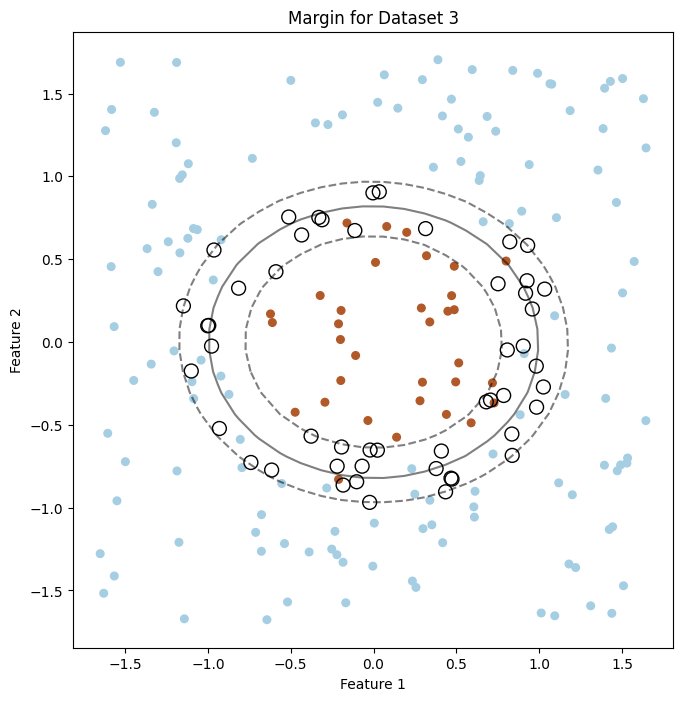

Number of support vectors :  50


In [32]:

plot_learning_curve_decision_boundary_margin(best_params, X_test, y_test, accuracy, best_estimator, "Dataset 3")

# Print the best parameters using Bayes Search

In [ ]:
bayes_search_results = best_parameters_with_bayes_search(X_train, y_train)

# Plot learning curve using best parameters obtained using Bayes Search

In [ ]:
best_params['C'] = bayes_search_results.best_params_['C']
best_params['gamma'] = bayes_search_results.best_params_['gamma']
best_params['kernel'] = bayes_search_results.best_params_['kernel']
plot_learning_curve_decision_boundary_margin(best_params, X_test, y_test, bayes_search_results.best_score_, bayes_search_results.best_estimator_, "Dataset 3")

<span style="color:green">The number of support vectors = 25 and the best c value is 876.73 with gamma of 0.1 and rbf kernel as per the Bayes search, with an accuracy score of 0.7746268656716417. The number of support vectors is halved from 50 to 25, as a result we see a tighter gap between the SVM</span>

# **`Neural Network`**

## Load data for Dataset 2

In [ ]:
df_train, df_test = load_data_dataset("dataset_2_train.csv", "dataset_2_test.csv")
X_train, y_train, X_test, y_test = load_train_test_data(df_train, df_test)

## Train MLPClassifier

In [ ]:
def train_MLPClassifier(X_train, y_train):
  # using MLPClassifier
  clf = MLPClassifier(hidden_layer_sizes=(50, 50), activation='relu', alpha = 0.1, random_state = 42)
  # fit the model to train data
  clf.fit(X_train, y_train)
  return clf

## Predict for test data

In [ ]:
def predict_for_test_data(clf, X_test):
  # predict for the test data
  y_pred = clf.predict(X_test)
  return y_pred

## Calculate Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
def calculate_accuracy_score(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy using MLP Classifier :", accuracy)
  return accuracy

In [ ]:
# train MLPClassifier using train data
clf = train_MLPClassifier(X_train, y_train)
# predict for test data
y_pred = predict_for_test_data(clf, X_test)
# print accuracy score
accuracy = calculate_accuracy_score(y_test, y_pred)

<span style="color:green">The accuracy score of the model with hidden_layer_sizes=(50, 50), activation='relu', alpha = 0.1 is 0.7673</span>

# Function : plot learning curve and decision boundary

In [ ]:
def plot_learning_curve_decision_boundary(X_test, y_test, clf, accuracy):
  # plot learning curve for the best estimator
  plot_learning_curve(clf, f"MLP Classifier with accuracy value of {accuracy}", X_test, y_test).show()
  # plot decision boundary
  plot_decisions(X_test.values, y_test.values, f"MLP Classifier with accuracy value of {accuracy}", clf)
  # plot margin for dataset 2
  # plot_margin(X_test.values, y_test.values, clf, "Margin for using MLP Classifier")

# Plot learning curve and decision boundary

In [ ]:
plot_learning_curve_decision_boundary(X_test, y_test, clf, accuracy)

# Find the best parameters using Bayes Search for Neural Network

In [ ]:
optNN1.fit(X_train, y_train)
print("Best parameters for Dataset 2 Neural Network by Bayes Search", optNN1.best_params_, "with accuracy", optNN1.best_score_)

<span style="color:green">Best Neural Network hyperparameters by Bayes Search [('activation', 'tanh'), ('alpha', 0.09908726974650425), ('layer1', 11), ('layer2', 20)] with accuracy 0.7656716417910449</span>

# Plot the graph for best model identified with Bayes Search

In [ ]:
plot_learning_curve_decision_boundary(X_test, y_test, optNN1.best_estimator_, optNN1.best_score_)

<span style="color:red">Note: The accuracy here is less than the one obtained above. This would be due to the number of neurons in the above approach had 50 in each of the 2 layers. However, here we explored the space for only between 10 and 20 neurons. This provides us insight into the fact that we do not need 50 neurons in each layer to obtain an accuracy of 76%.</span>

## Load data for Dataset 3

In [ ]:
df_train, df_test = load_data_dataset("dataset_3_train.csv", "dataset_3_test.csv")
X_train, y_train, X_test, y_test = load_train_test_data(df_train, df_test)

## Train and predict data

In [ ]:
# train MLPClassifier using train data
clf = train_MLPClassifier(X_train, y_train)
# predict for test data
y_pred = predict_for_test_data(clf, X_test)
# print accuracy score
accuracy = calculate_accuracy_score(y_test, y_pred)

In [ ]:
plot_learning_curve_decision_boundary(X_test, y_test, clf, accuracy)

<span style="color:green">The accuracy score of the model with hidden_layer_sizes=(50, 50), activation='relu', alpha = 0.1 is 0.9696</span>

# Bayes Search to obtain best parameters for Dataset 3

In [ ]:
optNN1.fit(X_train, y_train)
print("Best parameters for Dataset 3 Neural Network by Bayes Search", optNN1.best_params_)

# Plot graph with the best parameters for Dataset 3

In [ ]:
plot_learning_curve_decision_boundary(X_test, y_test, optNN1.best_estimator_, optNN1.best_score_)

<span style="color:green">Best parameters for Dataset 3 Neural Network by Bayes Search ([('activation', 'relu'), ('alpha', 0.09402113933718989), ('layer1', 10), ('layer2', 20)]) with accuracy of 0.973134328358209.</span>

<span style="color:red">Note: The accuracy here is less than the one obtained above. This would be due to the number of neurons in the above approach had 50 in each of the 2 layers. However, here we explored the space for only between 10 and 20 neurons. This provides us insight into the fact that we do not need 50 neurons in each layer to obtain an accuracy of 76%.</span>

# **INITIAL POST**

Task 2 entailed exploration of hyperparameters for SVM and Neural Networks. Initially I tried to approach the problem as @CongLiu did using the grid search because the Bayes Search library had an issue with the 'int'. However, during the QnA activity on the Tuesday of week 6, I found a comment posted there by @RuiAlexandre FaustinoDe that helped me which was to convert the int to np.int64. This helped me tackle the issue with the Bayes Search. Hope this information will help someone.

Both approaches are available in my notebook. I observed that when having a large number of parameters in the Bayes Search and Grid Search, the Bayes Search did outperform the Grid Search wrt time taken. Because I was running this on Colab and the GPU availability was time restricted I reduced the number of Iterations to 50 as suggested in the QnA session during my trials. The following are my observations:

For Dataset 2 :

Approached Grid Search with a few different parameters:

Found The best parameters are : {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'} Accuracy of Dataset 2 with rbf kernel with gamma value of 0.1 and C value of 100 is : 0.7643504531722054. Number of support vectors : 370.

The grid values I tried to apply after a few filtration

{'C': [0.0001, 0.001, 0.01, 0.1, 10, 100], 'kernel': ['linear']},
{'C': [0.0001, 0.001, 0.01, 0.1, 10, 100], 'gamma': [0.001, 0.01, 0.1], 'kernel': ['rbf']},
{'C': [0.0001, 0.001, 0.01, 0.1, 10, 100], 'gamma': [0.001, 0.01, 0.1], 'kernel': ['poly'], 'degree':[2,3,4]}]
Approached Bayes Search with a few different parameters:

Best Parameters:('C', 34.83719088201435), ('gamma', 0.1), ('kernel', 'rbf')]) Accuracy: 0.7583081570996979.

Note : In the Grid search approach I defined the C = 100 as a criteria. However, with the Bayes Search I was interested to find the best C value that is obtained using the Bayes Search. Hence the difference in C values. After obtaining the C value from Bayes Search I approached the Grid Search with the C value and obtained from the Bayes Search and the optimum C value reported by Grid Search matched with the Bayes Search. This provides a trustable result.

Hence for Dataset 2, the optimum parameters I identified are,

The best parameters are : {'C': 34, 'gamma': 0.1, 'kernel': 'rbf'} Accuracy of Dataset 2 with rbf kernel with gamma value of 0.1 and C value of 34 is : 0.7583081570996979. Number of support vectors : 381

What's interesting here is the accuracy I obtained when approaching the grid search without the C values(C=33,34) I found using Bayes Search is higher(though not significantly higher). This might be due to the other metrics such as F1 score, Precision and Recall differing.I wonder why this is. Also note, the number of support vectors also increased from 370 to 381. This should mean a better generalization at the cost of test accuracy. If anyone could shed light on this, it would be fantastic.

For Dataset 3 :

Approached Grid Search with a few different parameters:

The best parameters are : {'C': 100, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'} Accuracy of Dataset 3 with poly kernel with gamma value of 0.1 and degree of 2 and C value of 100 is : 0.9636363636363636.

Number of support vectors : 50

Approached Bayes Search with a few different parameters:
Best Parameters: ('C', 876.7830041724807),('gamma', 0.1), ('kernel', 'rbf')]) Accuracy: 0.9701492537313433

Number of support vectors : 25

Note: Here we see a tighter gap between the SVMs

For Neural Networks with hidden layer size as (10,20):

Dataset 2:
Accuracy using MLP Classifier : 0.7643504531722054

Best parameters for Dataset 2 Neural Network by Bayes Search ([('layer1', 13), ('layer2', 20)]

Dataset 3:

MLP Classifier with accuracy value of 0.9757575757575757

Best parameters for Dataset 3 Neural Network by Bayes Search OrderedDict([('layer1', 15), ('layer2', 18)])

## Reflection


Things Learned:
I learned of two ways to find optimal parameters : Grid Search and Bayes Search
I also learned about different activation functions and effect of different kernels on the datasets and how accuracy would vary when choosing different hyperparameters for different datasets.

Initially I tried testing different kernels and degrees of functions randomly on the given datsets. However, later I found that there exists a different way to obtain the best hyperparameters for a dataset. I verified and compared the 2 different methods(Grid Search and Bayes Search). Both of these has a comparable performance.

I was initially stuck at task 2, however on viewing the code done by Cong Liu(22030573), I was able to understand the question for task 2. I did not know how to use the grid search, but his code helped me understand the grid search approach along with the explaination done by Prof. Pepijn cleared up what is being done by Grid Search and what is the difference between Bayes Search and Grid Search(the area explored is from a grid for grid search). This helped me test the results obtained using Grid Search and Bayes Search and was able to observe that the difference in the suggestions for hyperparameters were minimal.